# What's with the negative parallaxes? A simplified demonstration of why a measured parallax can be negative

Any astrometric catalogue that lists parallaxes will contain negative parallaxes, which at first sight appear physically implausible, yet they are an entirely valid measurement of the true positive parallax in the presence of (large) noise. This notebook discusses how negative parallaxes may arise even for "perfect" measurements (suffering only from random Gaussian noise, without any systematic uncerainties).

The astrometry of stars is modelled traditionally as the stars having a uniform motion with respect to the solar system barycentre, which leads to the following description of the apparent (topocentric) direction on the sky as a function of time (see [Lindegren et al. 2012](https://ui.adsabs.harvard.edu/#abs/2012A&A...538A..78L/abstract), and the [Hipparcos, Section 1.2](https://ui.adsabs.harvard.edu/#abs/1997ESASP1200.....E/abstract) and [Gaia DR1](https://gaia.esac.esa.int/documentation//GDR1/Data_processing/chap_cu3ast/sec_cu3ast_intro.html#SS4) documentation for details)

\begin{equation}
    \boldsymbol{u}(t) = \langle \boldsymbol{r} + (t_\mathrm{B}-t_\mathrm{ep})
    (\boldsymbol{p}\mu_{\alpha*} + \boldsymbol{q}\mu_\delta + \boldsymbol{r}\mu_r) - 
    \varpi\boldsymbol{b}_\mathrm{O}(t)/A_\mathrm{u} \rangle\,,
\end{equation}

where $t$ is the time of observation and $t_\mathrm{ep}$ is the reference epoch for the astrometric parameters (both in Barycentric Coordinate Time or TCB units); $\boldsymbol{p}$, $\boldsymbol{q}$, and $\boldsymbol{r}$ are unit vectors defined in terms of $\alpha$ and $\delta$, $t_\mathrm{B}=t+\boldsymbol{r}'\boldsymbol{b}_\mathrm{O}(t)/c$ is the time of observation corrected for the Roemer delay; $\boldsymbol{b}_\mathrm{O}(t)$ is the barycentric position of the observer at the time of observation; and $A_\mathrm{u}$ is the astronomical unit. $\langle\rangle$ denotes vector normalization ($\langle\boldsymbol{a}\rangle=\boldsymbol{a}|\boldsymbol{a}|^{-1}$), and the prime in $\boldsymbol{r}'$ stands for the transpose of a vector or matrix. The components of proper motion along $\boldsymbol{p}$ and $\boldsymbol{q}$ are $\mu_{\alpha*}=\mu_\alpha\cos\delta$ and $\mu_\delta$, respectively, $\varpi$ is the parallax, and $\mu_r=v_r\varpi/A_\mathrm{u}$ is the "radial proper motion" which accounts for the fact that the distance to the to star changes as a consequence of its radial motion, which in turn affects the proper motion and parallax. The orthogonal vectors $\boldsymbol{p}$, $\boldsymbol{q}$, and $\boldsymbol{r}$ are defined as

\begin{equation}
    \boldsymbol{p} = \begin{pmatrix}
        -\sin\alpha \\ \cos\alpha \\ 0
    \end{pmatrix}\,, \quad
    \begin{matrix}
        \boldsymbol{q} = \begin{pmatrix}
            -\sin\delta\cos\alpha \\ -\sin\delta\sin\alpha \\ \cos\delta
        \end{pmatrix}
    \end{matrix}\,, \quad
    \boldsymbol{r} = \begin{pmatrix}
        \cos\delta\cos\alpha \\ \cos\delta\sin\alpha \\ \sin\delta
    \end{pmatrix}\,.
\end{equation}

These vectors define the so-called normal triad indicating the directions of increasing right ascension $\boldsymbol{p}$, increasing declination $\boldsymbol{q}$, and the coordinate direction of the star $\boldsymbol{r}$.

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import uniform, norm, chi2
from scipy.linalg import lstsq, inv

from astropy import constants
from astropy import units
import corner

from plotstyles import useagab, apply_tufte
from pygaia.astrometry.coordinates import CoordinateTransformation, Transformations
from pygaia.astrometry import constants as pygcst
from pygaia.astrometry.vectorastrometry import astrometryToPhaseSpace

## Simplified simulation of astrometric observations of a source

The code below simulates the observer as being on a circular orbit around the sun, exactly in the ecliptic plane, and with an orbital radius of 1 AU. The topocentric coordinate direction $\boldsymbol{u}_\mathrm{O}$ of the source as a function of time is calculated as

\begin{equation}
    \boldsymbol{u}_\mathrm{O}(t) = \langle \boldsymbol{b}(t_\mathrm{ep}) + 
    \boldsymbol{v}(t-t_\mathrm{ep}) - \boldsymbol{b}_\mathrm{O}(t)\rangle =
    \begin{pmatrix}
        \cos\delta(t)\cos\alpha(t) \\ \cos\delta(t)\sin\alpha(t) \\ \sin\delta(t)
    \end{pmatrix}\,.
\end{equation}

The simulated observations are subsequently reported as

\begin{equation}
    \Delta\alpha* = (\alpha(t)-\alpha(t_\mathrm{ep}))*\cos\delta(t_\mathrm{ep}) \quad\text{and}\quad
    \Delta\delta = \delta(t)-\delta(t_\mathrm{ep})
\end{equation}

where the quantities $\Delta\alpha*$ and $\Delta\delta$ are modelled in the code below in very simplified fashion as

\begin{gather}
    \Delta\alpha* \approx (t_\mathrm{B}-t_0)\mu_{\alpha*} -
    \varpi\boldsymbol{p}'\boldsymbol{b}_\mathrm{O}(t)/A_\mathrm{u} \\
    \Delta\delta \approx (t_\mathrm{B}-t_0)\mu_{\delta} -
    \varpi\boldsymbol{q}'\boldsymbol{b}_\mathrm{O}(t)/A_\mathrm{u}\,.
\end{gather}

This is a simplified astrometric model of the source cast in local plane coordinates and ignoring the details of the normalization of the vector $\boldsymbol{u}_\mathrm{O}$.

**NOTE:** the code below is not numerically robust. It will fail at $\alpha=0$ and $\delta=\pm\pi/2$. In addition the simple system of equations to solve for the parallax and proper motion from the observations will not work in the presence of substantial perspective acceleration.

In [171]:
def ephemeris_earth(t):
    """
    Calculate a very simple ephemeris for "earth" in the BCRS. Assume a perfectly
    circular orbit of exactly 1 AU radius with a 1 yr period.
    
    Parameters
    ----------
    
    t : float array
        Times at which to calculate the ephemeris in Julian years.
        
    Returns
    -------
    
    Array of shape (3,t.size) representing the xyz components of the ephemeris at times t.
    """
    ecltoicrs = CoordinateTransformation(Transformations.ECL2ICRS)
    orbitalperiod = 1.0 #(Julian yr)
    orbitalradius = 1.0 #(AU)
    (b_xecl, b_yecl, b_zecl) = (orbitalradius*np.cos(2*np.pi/orbitalperiod*t), 
                                orbitalradius*np.sin(2*np.pi/orbitalperiod*t), t*0)
    b_xicrs, b_yicrs, b_zicrs = ecltoicrs.transformCartesianCoordinates(b_xecl, b_yecl, b_zecl)
    return np.vstack([b_xicrs, b_yicrs, b_zicrs])
    
def calc_epoch_topocentric(alpha, delta, parallax, mura, mudec, vrad, t, refepoch, ephem, eqMat=False):
    """
    Calculate the topocentric epoch positions delta_alpha*cos(delta) and delta_delta given the
    astrometric parameters of a source, the observation times, and the ephemeris (in the BCRS) for
    the observer.
    
    Parameters
    ----------
    
    alpha : float
        Right ascension at reference epoch (radians)
    delta : float
        Declination at reference epoch (radians)
    parallax : float
        Parallax (mas)
    mura : float
        Proper motion in right ascension, including cos(delta) factor (mas/yr)
    mudec : float
        Proper motion in declination (mas/yr)
    vrad : float
        Radial velocity (km/s)
    t : float array
        Observation times (Julian year)
    refepoch : float
        Reference epoch (Julian year)
    ephem : function
        Funtion providing the observers ephemeris in BCRS at times t (units of AU)
        
    Keywords
    --------
    
    eqMat : boolean
        If True return the equations matrix for solving for proper motion and parallax from a
        set of observations (simplified: ignores radial motion effect and assumes perfectly known
        observation times and a perfectly known position at the reference epoch).
        
    Returns
    -------
    
    Arrays delta_alpha* and delta_delta (local plane coordinates with respect to (alpha, delta)).
    """
    mastorad = np.pi/(180*3600*1000)
    
    if parallax<0:
        signparallax=1
    else:
        signparallax=-1

    # apparent phase space coordinates at reference epoch
    bS_x, bS_y, bS_z, vS_x, vS_y, vS_z = astrometryToPhaseSpace(alpha, delta, np.abs(parallax), mura, mudec, vrad)
    # Apparent phase space coordinates for the observation times, ignore differential light-time effects.
    bS_icrs = np.zeros((3,t.size))
    bS_icrs[0,:] = bS_x+vS_x*(t-refepoch)*(1000*pygcst.julianYearSeconds/pygcst.parsec)
    bS_icrs[1,:] = bS_y+vS_y*(t-refepoch)*(1000*pygcst.julianYearSeconds/pygcst.parsec)
    bS_icrs[2,:] = bS_z+vS_z*(t-refepoch)*(1000*pygcst.julianYearSeconds/pygcst.parsec)
    
    bO_icrs = ephem(t)
    uO = bS_icrs + signparallax * bO_icrs*pygcst.auInMeter/pygcst.parsec
    alpha_obs = np.arctan2(uO[1,:], uO[0,:])
    indices = (alpha_obs<0)
    alpha_obs[indices] = alpha_obs[indices]+2*np.pi
    delta_obs = np.arcsin(uO[2,:]/np.linalg.norm(uO,axis=0))
                          
    delta_alpha = (alpha_obs - alpha)*np.cos(delta)/mastorad
    delta_delta = (delta_obs - delta)/mastorad
    
    p = np.array([-np.sin(alpha), np.cos(alpha), 0.0])
    q = np.array([-np.sin(delta)*np.cos(alpha), -np.sin(delta)*np.sin(alpha), np.cos(delta)])
    r = np.array([np.cos(delta)*np.cos(alpha), np.cos(delta)*np.sin(alpha), np.sin(delta)])

    tB = t + (np.dot(r,bO_icrs))*pygcst.auInMeter/(pygcst.julianYearSeconds*constants.c.value)
    murad = vrad*parallax/(1000*pygcst.auKmYearPerSec)
    zetarad = vrad*parallax/(1000*pygcst.auMasKmYearPerSec)

    #pdotu = (tB-refepoch)*mura - parallax*(np.dot(p,bO_icrs))
    #qdotu = (tB-refepoch)*mudec - parallax*(np.dot(q,bO_icrs))
    #rdotu = 1.0/mastorad + (tB-refepoch)*murad - parallax*(np.dot(r,bO_icrs))

    #delta_alpha = np.arctan(pdotu/rdotu)/mastorad
    #delta_delta = np.arctan(qdotu/rdotu)/mastorad
    
    if eqMat:
        norm = 1.0 + (tB-refepoch)*zetarad
        nobs = t.size
        A = np.zeros((2*nobs,3))
        A[0:nobs,0] = -np.dot(p,bO_icrs)/norm
        A[nobs:2*nobs,0] = -np.dot(q,bO_icrs)/norm
        A[0:nobs,1] = (tB-refepoch)/norm
        A[nobs:2*nobs,2] = (tB-refepoch)/norm
        return delta_alpha, delta_delta, A
    else:
        return delta_alpha, delta_delta

In [100]:
refepoch = 2015.5
startepoch = 2014.5
endepoch = 2019.5
nobs = 10
    
time = np.linspace(startepoch, endepoch, 1000)
tobs_sample = uniform.rvs(loc=startepoch, scale=endepoch-startepoch, size=nobs)

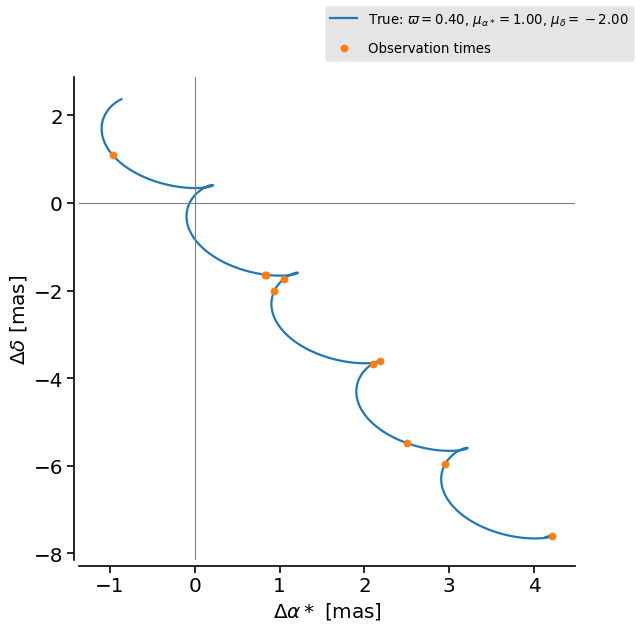

In [205]:
# source astrometric parameters at reference epoch

# Barnard's star
#alpha = 4.7028598776 #(66.0*units.degree).to(units.rad).value
#delta = 0.0814769927 #(16*units.degree).to(units.rad).value
#parallax = 548.31 # mas
#mura = -798.58          # mas/yr
#mudec = 10328.12        # mas/yr
#vrad = -110.51           # km/s

# Star at small parallax
alpha = (200.0*units.degree).to(units.rad).value
delta = (80.0*units.degree).to(units.rad).value
parallax = 0.4 # mas
mura =  1        # mas/yr
mudec = -2       # mas/yr
vrad = 40           # km/s

delta_alpha, delta_delta = calc_epoch_topocentric(alpha, delta, parallax, mura, mudec,
                                                  vrad, time, refepoch, ephemeris_earth)
delta_alpha_sample, delta_delta_sample, A = calc_epoch_topocentric(alpha, delta, parallax, mura, mudec,
                                                                   vrad, tobs_sample, refepoch, 
                                                                   ephemeris_earth, eqMat=True)

useagab(usetex=False, sroncolours=False, fontfam='sans')
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
apply_tufte(ax)

ax.plot(delta_alpha, delta_delta, 
        label=r'True: $\varpi={0:.2f}$, $\mu_{{\alpha*}}={1:.2f}$, $\mu_\delta={2:.2f}$'.
        format(parallax, mura, mudec), lw=2)
ax.plot(delta_alpha_sample, delta_delta_sample, 'o', 
        label=r'Observation times'.
        format(parallax, mura, mudec), lw=2)
#ax.plot(delta_alpha[0], delta_delta[0], 'x', ms=20)
ax.set_xlabel(r'$\Delta\alpha*$ [mas]')
ax.set_ylabel(r'$\Delta\delta$ [mas]')
ax.axhline(y=0, c='gray', lw=1)
ax.axvline(x=0, c='gray', lw=1)
fig.legend(loc='upper right', fontsize=12,  facecolor='#000000', framealpha=0.1,
         labelspacing=1)

plt.savefig('source_motion.pdf')
plt.show()

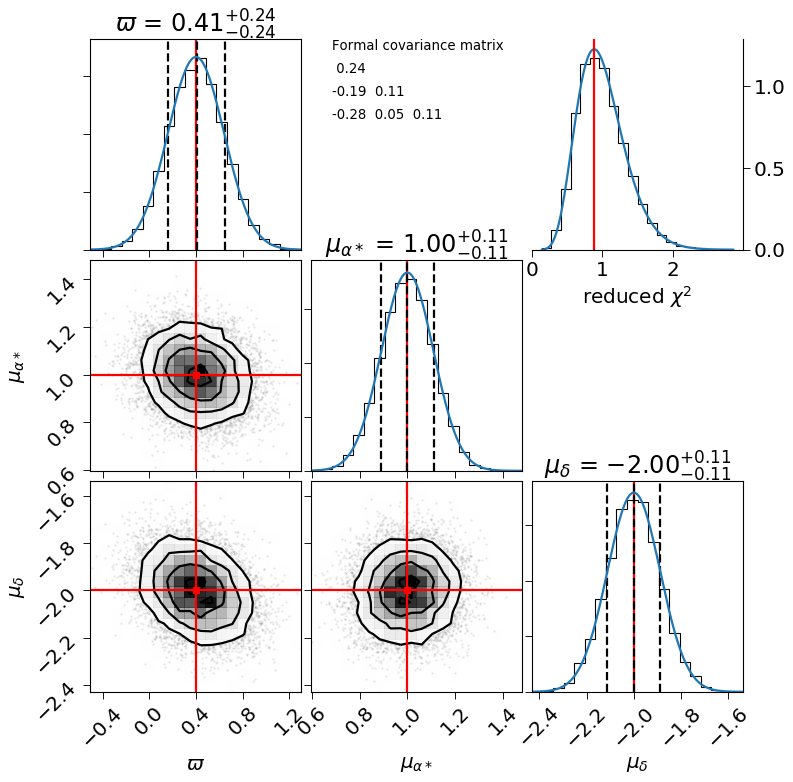

In [210]:
meas_unc = 0.7 # Instantaneous measurement uncertainty in alpha*cos(delta) and delta (mas)
covmat = inv(np.dot(A.T,A))*meas_unc**2

covmattext = "Formal covariance matrix\n"
covmattext = covmattext + "{0:5.2f}\n".format(np.sqrt(covmat[0,0]))
covmattext = covmattext + "{0:5.2f} {1:5.2f}\n".format(covmat[1,0]/np.sqrt(covmat[0,0]*covmat[1,1]),
                                                     np.sqrt(covmat[1,1]))
covmattext = covmattext + "{0:5.2f} {1:5.2f} {2:5.2f}\n".format(covmat[2,0]/np.sqrt(covmat[0,0]*covmat[2,2]), 
                                       covmat[2,1]/np.sqrt(covmat[1,1]*covmat[2,2]),
                                       np.sqrt(covmat[2,2]))

# Make N realizations of the measurements for the same source at the same observing times.
Nsims = 10000
params = np.zeros((Nsims,3))
chisq = np.zeros(Nsims)
allobs = np.zeros((Nsims, 2*nobs))
dof = 2*nobs-3
for i in range(Nsims):
    delta_alpha_obs = norm.rvs(loc=delta_alpha_sample, scale=meas_unc)
    delta_delta_obs = norm.rvs(loc=delta_delta_sample, scale=meas_unc)
    zobs = np.hstack([delta_alpha_obs, delta_delta_obs])
    allobs[i] = zobs
    sol, residues, rank, s = lstsq(A/meas_unc, zobs/meas_unc)
    chisq[i] = residues/dof
    params[i] = sol
    
fig = plt.figure(figsize=(10,10))
ax = []
for i in range(1,10):
    ax.append(fig.add_subplot(3,3,i))
corner.corner(params, labels=[r'$\varpi$', r'$\mu_{\alpha*}$', r'$\mu_\delta$'], truths=[parallax, mura, mudec],
              truth_color='r', quantiles=[0.16,0.50,0.84], show_titles=True, fig=fig,
              hist_kwargs={'normed':True})
x = np.linspace(params[:,0].min(), params[:,0].max(), 1000)
ax[0].plot(x, norm.pdf(x, loc=parallax, scale=np.sqrt(covmat[0,0])), lw=2)
x = np.linspace(params[:,1].min(), params[:,1].max(), 1000)
ax[4].plot(x, norm.pdf(x, loc=mura, scale=np.sqrt(covmat[1,1])), lw=2)
x = np.linspace(params[:,2].min(), params[:,2].max(), 1000)
ax[8].plot(x, norm.pdf(x, loc=mudec, scale=np.sqrt(covmat[2,2])), lw=2)

axchisq = fig.add_subplot(3,3,3, label='chisq')
axchisq.hist(chisq, bins=20, normed=True, histtype='step', color='k')
x = np.linspace(chisq.min(), chisq.max(), 1000)
axchisq.plot(x, chi2.pdf(x*dof, dof)*dof, lw=2)
axchisq.set_xlabel(r'reduced $\chi^2$')
axchisq.yaxis.set_ticks_position('right')
axchisq.spines['left'].set_visible(False)
axchisq.spines['top'].set_visible(False)
axchisq.axvline(x=1.0-2.0/dof, color='r')

#axcov = fig.add_subplot(3,3,2, label='cov')
ax[4].text(0.1,1.8, covmattext, ha='left', va='center', linespacing=1.8, size=12, transform=ax[4].transAxes)

plt.savefig("simulated_lsq_solutions.pdf")
plt.show()

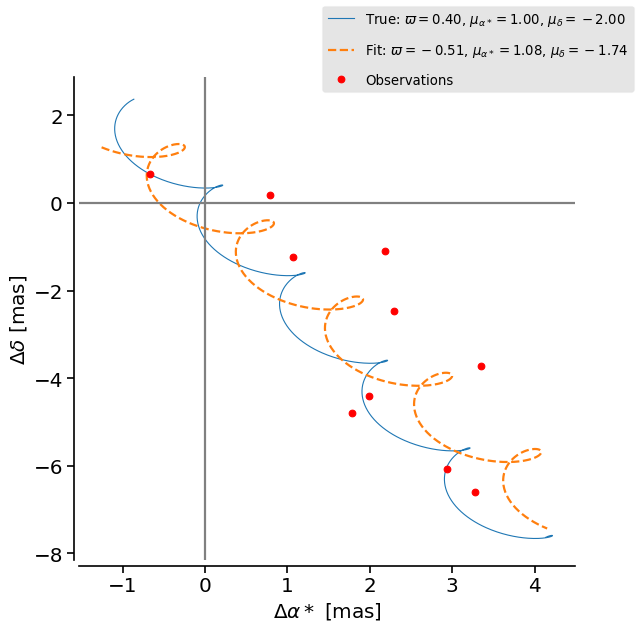

In [211]:
minparind = np.argmin(params[:,0])

delta_alpha_fit, delta_delta_fit = calc_epoch_topocentric(alpha, delta, params[minparind,0], params[minparind,1], 
                                                          params[minparind,2],
                                                          vrad, time, refepoch, ephemeris_earth)

useagab(usetex=False, sroncolours=False, fontfam='sans')
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
apply_tufte(ax)

ax.plot(delta_alpha, delta_delta, 
        label=r'True: $\varpi={0:.2f}$, $\mu_{{\alpha*}}={1:.2f}$, $\mu_\delta={2:.2f}$'.
        format(parallax, mura, mudec), lw=1)
ax.plot(delta_alpha_fit, delta_delta_fit, 
        label=r'Fit: $\varpi={0:.2f}$, $\mu_{{\alpha*}}={1:.2f}$, $\mu_\delta={2:.2f}$'.
        format(params[minparind,0], params[minparind,1], params[minparind,2]), lw=2, ls='--')
ax.plot(allobs[minparind,0:nobs], allobs[minparind,nobs:2*nobs], 'or', label='Observations')
#ax.plot(delta_alpha[0], delta_delta[0], 'x', ms=20)
#ax.plot(delta_alpha_fit[0], delta_delta_fit[0], 'xk', ms=20)
ax.set_xlabel(r'$\Delta\alpha*$ [mas]')
ax.set_ylabel(r'$\Delta\delta$ [mas]')
ax.axhline(y=0, c='gray')
ax.axvline(x=0, c='gray')
fig.legend(loc='upper right', fontsize=12,  facecolor='#000000', framealpha=0.1,
         labelspacing=1)

plt.savefig("minimum_parallax_solution.pdf")
plt.show()